In [1047]:
# warnings....ignore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.options.mode.chained_assignment = None

In [1048]:
DATA = []
BUCKETS = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
TIME_VECTOR = 5 # second

### Load sample data from json file
Sample format row data:
```python
{"timestamp": "23/01/2024, 10:44:34", "path": "/users", "method": "GET", "service_name": "process_log", "controller_pod": "pod-1", "duration_time": 0.176}
```

In [1049]:
import json


def get_data_from_file(filename: str):
    f = open(filename, "r")
    while True:
        line = f.readline()
        if not line:
            break
        # Standardlize json to dict
        row = json.loads(line)
        # Append to Array
        DATA.append(row)

In [1050]:
get_data_from_file("../statics/request_data_with_anomaly_pod_instance.json")

In [1051]:
group_by_el = ["path", "method", "service_name", "controller_pod"]

### Fill sample data to Dataframe
Columns list: **[timestamp, path, method, service_name, controller_pod, duration_time]**

In [1052]:
# Create dataframe
root_df = pd.DataFrame(DATA)

<Axes: title={'center': 'Duration time'}, ylabel='Frequency'>

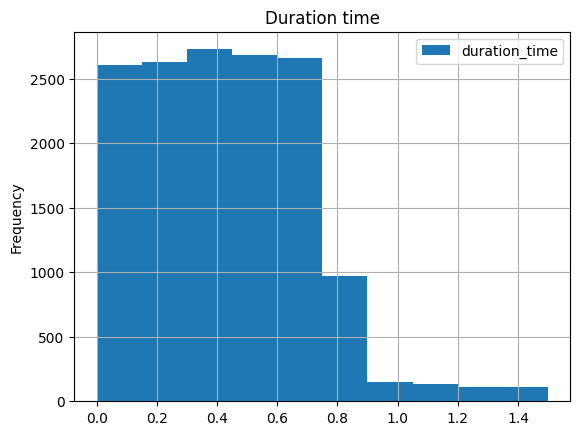

In [1053]:
root_df.plot(
    x="timestamp",
    y="duration_time",
    grid=True,
    title="Duration time",
    kind="hist",
    label='duration_time'
)
# plt.show()

Từ histogram có thể thấy độ phủ request duration rơi nhiều vào các bucket từ 0.1 -> 0.7. Tuy nhiên, vẫn có khá nhiều request có duration_time lớn (request mất nhiều thời gian xử lý) trong dataset trong khoảng từ [1 -> 1.6 seconds]


Khi xác định được tình trạng tổng quan và vấn đề của toàn bộ hệ thống đang gặp phải, tiến hành phân tích chuyên sâu để tìm ra nguyên nhân cốt lõi dẫn đến vấn đề. Bước thực hiện sau đây sẽ truy xuất tình trạng hệ thống dựa trên các nhóm dịch vụ để "zoom-in" vào từng thành phần của hệ thống. 

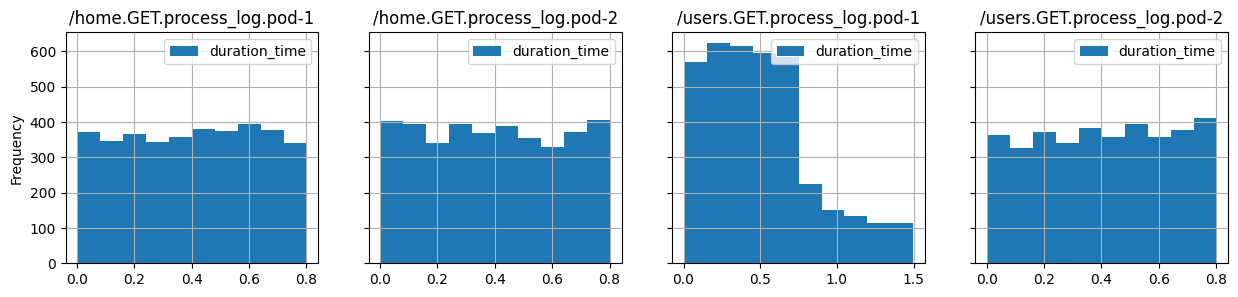

In [1054]:
# Plot histogram by each group
grouped = root_df.groupby(group_by_el)
fig, axs = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
for (name, df), ax in zip(grouped, axs.flat):
    name = ".".join(list(name))
    df.plot(kind="hist", ax=ax, title=name, grid=True)

Từ các mẫu thống kê được cho thấy độ phủ thời gian xử lý của tất cả các mẫu rơi vào ngưỡng <= 0.8 seconds. Tuy nhiên riêng mẫu thứ 3 từ trái sang xuất hiện khá nhiều những request có duration_time trong khoảng từ [1.0 seconds -> 1.5 seconds]. Những request có duration_time này được coi là những request chậm. Vì vậy có thể xác định nguyên nhân chậm của toàn bộ service do mẫu thứ 3 này (instance: path=/users, controller_pod=pod-1) 

In [1089]:
instance_abnormal = "path == '/users' and controller_pod == 'pod-1'" # <- Declare instance for consider

### (On the sidelines) Xác định những khoảng thời gian instance có request latency cao

<Axes: title={'center': 'Slow request duration of instance path=/users and controller_pod=pod-1 \n by index'}>

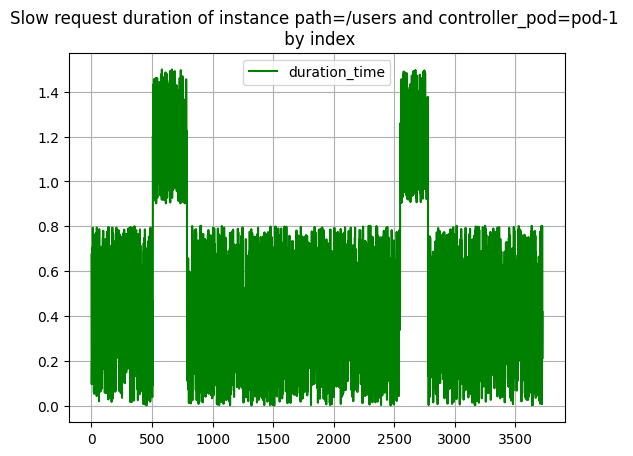

In [1087]:
# Plot line chart for detect time range of problem by group
root_df.query(instance_abnormal).reset_index().plot(
    kind="line",
    title="Slow request duration of instance path=/users and controller_pod=pod-1 \n by index",
    grid=True,
    y="duration_time",
    color="green",
)


Từ kết quả trên cho thấy được giai đoạn có nhiều request latency cao nằm trong ngưỡng index từ [500, <1000] và [>2500, <3000]

Từ đó có thể lấy ra được khoảng thời gian

<Axes: xlabel='timestamp'>

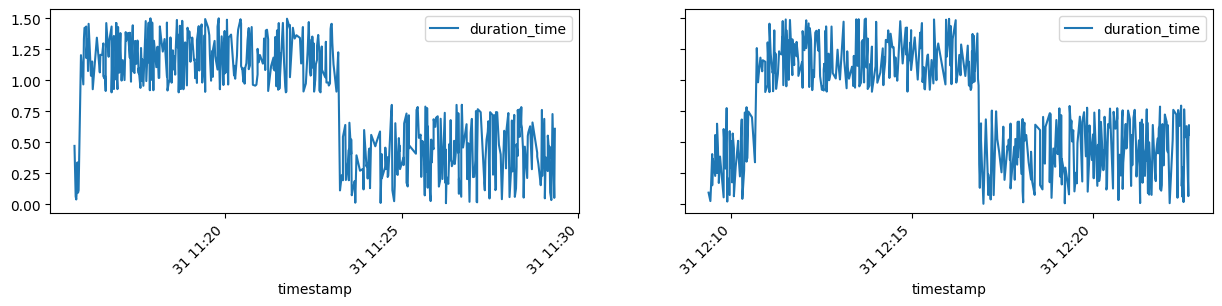

In [1088]:
# From index => time range
# Plot line chart for detect time range of problem by group
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 3), sharey=True)
root_df.query(instance_abnormal).reset_index()[500:1000].plot(
    kind="line",
    rot=45,
    y="duration_time",
    ax=axs[0],
    x="timestamp"
)
root_df.query(instance_abnormal).reset_index()[2500:3000].plot(
    kind="line",
    rot=45,
    y="duration_time",
    ax=axs[1],
    x="timestamp"
)

Sau khi xác định được khoảng thời gian xảy ra vấn đề, cần đánh giá ảnh hưởng của vấn đề đến dịch vụ liệu có vi phạm SLO hay không phụ thuộc vào SLI (Service-Level Indicator)

### SLI Calculate 

#### Standardilize data

In [1057]:
from datetime import datetime


# Re format timestamp to  "%d/%m/%Y, %H:%M:%S"
root_df['timestamp'] = root_df['timestamp'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y, %H:%M:%S"))
# Convert to datetime pandas and set datetime columns is index for dataframe
root_df['timestamp'] = pd.to_datetime(root_df['timestamp'])
root_df = root_df.set_index('timestamp')

In [1064]:
# Bins data to bucket latency
def bucketing(duration_time):
    res = []
    for bucket in BUCKETS:
        if duration_time <= bucket:
            res.append(bucket)
    res.append("+Inf")
    return res

root_df["le"] = root_df["duration_time"].apply(lambda x: bucketing(x))

In [1058]:
# Get distinct group for bins value latency for each group
group_dataset = root_df.groupby(group_by_el).count().reset_index()[group_by_el]

In [1065]:
group_dataset # <- Return all group existed in dataset, next step do bins value of each group into bucket list: **[0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, +Inf]** 

,path,method,service_name,controller_pod
0,/home,GET,process_log,pod-1
1,/home,GET,process_log,pod-2
2,/users,GET,process_log,pod-1
3,/users,GET,process_log,pod-2


In [1060]:
from typing import Dict


def bins_value(row, bins_dict: Dict):
    # unwind data from list
    list_le = row['le']
    for le in list_le:
        if le in bins_dict:
            bins_dict[le] += 1
    bins_series = pd.Series(
        data=bins_dict, index=bins_dict.keys()  # type: ignore
    )
    # Join two series
    new_row = pd.concat([row, bins_series])
    return new_row

In [1066]:
root_df

,path,method,service_name,controller_pod,duration_time,le
timestamp,,,,,,
2024-01-31 11:01:56,/home,GET,process_log,pod-1,0.242,"[0.25, 0.5, +Inf]"
2024-01-31 11:01:57,/users,GET,process_log,pod-2,0.439,"[0.5, +Inf]"
2024-01-31 11:01:57,/home,GET,process_log,pod-1,0.459,"[0.5, +Inf]"
2024-01-31 11:01:58,/home,GET,process_log,pod-1,0.252,"[0.5, +Inf]"
2024-01-31 11:01:58,/users,GET,process_log,pod-2,0.527,[+Inf]
...,...,...,...,...,...,...
2024-01-31 12:42:47,/users,GET,process_log,pod-1,0.800,[+Inf]
2024-01-31 12:42:48,/home,GET,process_log,pod-2,0.290,"[0.5, +Inf]"
2024-01-31 12:42:48,/users,GET,process_log,pod-1,0.209,"[0.25, 0.5, +Inf]"


In [1068]:
# Bins value to bucket latency
df_by_group = {}
for idx, dataset in group_dataset.iterrows():
    bins_dict = {k: 0 for k in BUCKETS}
    bins_dict['+Inf'] = 0  # type: ignore
    # Query for each group get dataframe and save it to datastructure
    df_by_group[idx] = root_df.query(
        "path == @dataset['path'] \
                and method == @dataset['method'] \
                and service_name == @dataset['service_name'] \
                and controller_pod == @dataset['controller_pod']")\
        .apply(lambda x: bins_value(x, bins_dict), axis=1)

# Join all group dataframe processed by one dataframe
df_by_group_incl_latency = pd.concat(df_by_group.values())

In [1070]:
# Rename columns
columns_change = {
    0.005: "le_0.005",
    0.01: "le_0.01",
    0.025: "le_0.025",
    0.05: "le_0.05",
    0.1: "le_0.1",
    0.25: "le_0.25",
    0.5: "le_0.5",
    "+Inf": "+Inf"
}
df_by_group_incl_latency = df_by_group_incl_latency.rename(columns=columns_change)

In [1071]:
df_by_group_incl_latency

,path,method,service_name,controller_pod,duration_time,le,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
timestamp,,,,,,,,,,,,,,
2024-01-31 11:01:56,/home,GET,process_log,pod-1,0.242,"[0.25, 0.5, +Inf]",0,0,0,0,0,1,1,1
2024-01-31 11:01:57,/home,GET,process_log,pod-1,0.459,"[0.5, +Inf]",0,0,0,0,0,1,2,2
2024-01-31 11:01:58,/home,GET,process_log,pod-1,0.252,"[0.5, +Inf]",0,0,0,0,0,1,3,3
2024-01-31 11:01:59,/home,GET,process_log,pod-1,0.183,"[0.25, 0.5, +Inf]",0,0,0,0,0,2,4,4
2024-01-31 11:01:59,/home,GET,process_log,pod-1,0.658,[+Inf],0,0,0,0,0,2,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 12:42:39,/users,GET,process_log,pod-2,0.676,[+Inf],21,45,125,230,433,1089,2239,3679
2024-01-31 12:42:45,/users,GET,process_log,pod-2,0.152,"[0.25, 0.5, +Inf]",21,45,125,230,433,1090,2240,3680
2024-01-31 12:42:45,/users,GET,process_log,pod-2,0.427,"[0.5, +Inf]",21,45,125,230,433,1090,2241,3681


In [1075]:
# Select columns necessary for analysis
list_column_select = ["path", "method", "service_name",
                      "controller_pod"] + [bucket for bucket in columns_change.values()]
df_by_group_incl_latency_bucket = df_by_group_incl_latency[list_column_select]

In [1076]:
df_by_group_incl_latency_bucket

,path,method,service_name,controller_pod,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
timestamp,,,,,,,,,,,,
2024-01-31 11:01:56,/home,GET,process_log,pod-1,0,0,0,0,0,1,1,1
2024-01-31 11:01:57,/home,GET,process_log,pod-1,0,0,0,0,0,1,2,2
2024-01-31 11:01:58,/home,GET,process_log,pod-1,0,0,0,0,0,1,3,3
2024-01-31 11:01:59,/home,GET,process_log,pod-1,0,0,0,0,0,2,4,4
2024-01-31 11:01:59,/home,GET,process_log,pod-1,0,0,0,0,0,2,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 12:42:39,/users,GET,process_log,pod-2,21,45,125,230,433,1089,2239,3679
2024-01-31 12:42:45,/users,GET,process_log,pod-2,21,45,125,230,433,1090,2240,3680
2024-01-31 12:42:45,/users,GET,process_log,pod-2,21,45,125,230,433,1090,2241,3681


<Axes: xlabel='timestamp'>

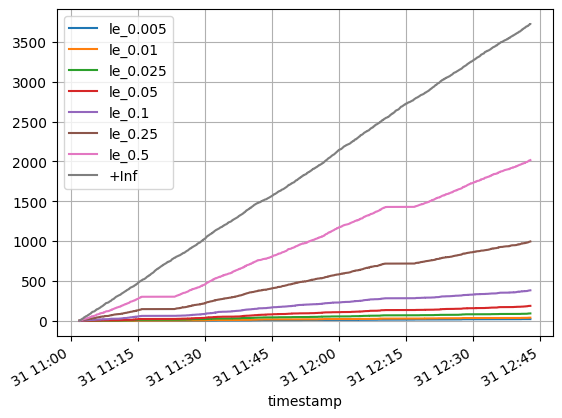

In [1090]:
df_by_group_incl_latency_bucket.query(instance_abnormal).plot(grid=True)

Nhìn kết quả trên chưa thể hiện nhiều sự khác biệt của vấn đề đối với hệ thống. Nhớ lại lúc trước đã xác định được khoảng thời gian khi vấn đề xảy ra, hãy zoom vào khoảng thời gian đó để nhận thấy sự khác biệt:

<Axes: xlabel='timestamp'>

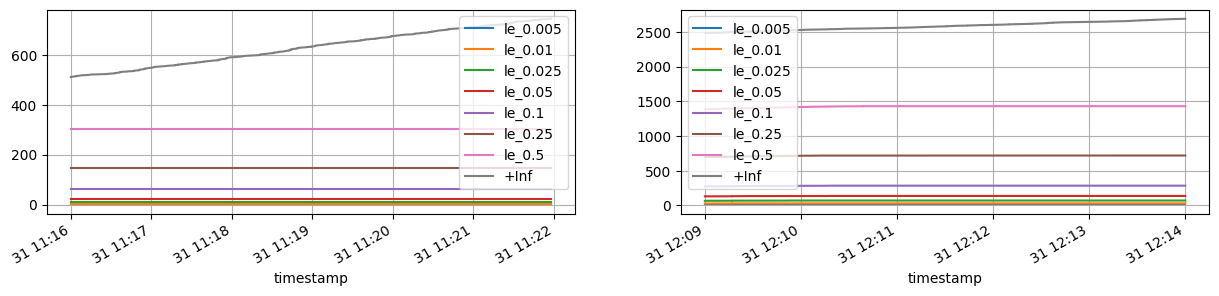

In [1085]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
df_by_group_incl_latency_bucket.query("path == '/users' and controller_pod == 'pod-1'").loc['2024-01-31 11:16:00': '2024-01-31 11:22:00'].plot(grid=True, ax=axs[0])
df_by_group_incl_latency_bucket.query("path == '/users' and controller_pod == 'pod-1'").loc['2024-01-31 12:09:00': '2024-01-31 12:14:00'].plot(grid=True, ax=axs[1])

Kết quả trên cho thấy được biến động đáng kể tại **bucket +Inf** trong khi các bucket khác đều không có biến động gì. Nghĩa là, có rất nhiều giá trị trong các khoảng thời gian này đa phần rơi vào bucket +Inf mà không rơi vào các bucket còn lại. Vì vậy, cho thấy rằng các request tại thời điểm đang xét đến của instance **instance_abnormal** được gán ở trên đều có duration_time > 0.5 ms (le=0.5 *<- Ngoài bucket này là vi phạm SLO*) 

In [ ]:
# Group data minimum interval 1 second
# Only consider about latency bucket -> Get newest value increament by second
df_by_group_incl_latency_bucket_interval = df_by_group_incl_latency_bucket.groupby(["timestamp"] + group_by_el).nth(-1)

In [1093]:
df_by_group_incl_latency_bucket_interval

,path,method,service_name,controller_pod,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
timestamp,,,,,,,,,,,,
2024-01-31 11:01:56,/home,GET,process_log,pod-1,0,0,0,0,0,1,1,1
2024-01-31 11:01:57,/home,GET,process_log,pod-1,0,0,0,0,0,1,2,2
2024-01-31 11:01:58,/home,GET,process_log,pod-1,0,0,0,0,0,1,3,3
2024-01-31 11:01:59,/home,GET,process_log,pod-1,0,0,0,0,0,2,4,5
2024-01-31 11:02:00,/home,GET,process_log,pod-1,0,0,0,0,0,2,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 12:42:36,/users,GET,process_log,pod-2,21,45,125,230,433,1089,2238,3677
2024-01-31 12:42:37,/users,GET,process_log,pod-2,21,45,125,230,433,1089,2239,3678
2024-01-31 12:42:39,/users,GET,process_log,pod-2,21,45,125,230,433,1089,2239,3679


In [ ]:
# Implement pct change for each bucket
raw_df_rolling = df_interval.groupby(group_by_el).rolling(window="5s").agg(lambda x: (x[-1] - x[0]) / x[0])  # type: ignore

<Axes: xlabel='timestamp'>

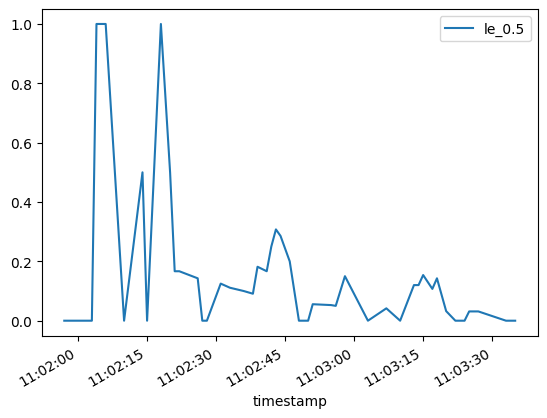

In [ ]:
raw_df_rolling.query("path == '/users' and controller_pod == 'pod-2'").fillna(0).reset_index()[0:50] \
.plot(x="timestamp", y="le_0.5")